## Structuring Sequences - POC

In [1]:
import os, sys
cwd = os.getcwd()
project_path = cwd[:cwd.find('pygents')+7]
if project_path not in sys.path: sys.path.append(project_path)
os.chdir(project_path) 

#from importlib import reload  # Python 3.4+

import pickle
import pandas as pd

#force reimport
if 'pygents.util' in sys.modules:
    del sys.modules['pygents.util']
if 'pygents.text' in sys.modules:
    del sys.modules['pygents.text']
if 'pygents.plot' in sys.modules:
    del sys.modules['pygents.plot']
if 'pygents.token' in sys.modules:
    del sys.modules['pygents.token']
if 'pygents.token_plot' in sys.modules:
    del sys.modules['pygents.token_plot']


from pygents.token import *
from pygents.text import *
from pygents.util import *
from pygents.plot import plot_bars, plot_dict, matrix_plot
from pygents.token_plot import *


### Get POC dataset 

In [22]:
texts = [
'мама мыла машу',
'маша мыла маму',
'маша ела кашу',
'мама ела кашу',
'маша ела суши',
'мама ела суши',
'мама мыла раму',
'маша мыла раму',
'мама мыла нишу',
'маша мыла нишу',
'мама мыла нашу машу',
'маша мыла нашу маму',
'мало мама мыла машу',
'мало маша мыла маму',
'мама мыла машу мылом',
'маша мыла маму мылом',
'маша ела мало каши',
'маша ела мало суши',
'мама ела мало суши',
'маша ела мало суши',
'мама мыла нашу машу мылом',
'маша мыла нашу маму мылом',
'мало мама мыла машу мылом',
'мало маша мыла маму мылом',
'мало мама мыла нашу машу мылом',
'мало маша мыла нашу маму мылом',
    
'соня идет тут',
'соня сидит тут',
'сеня идет тут',
'сеня сидит тут',
'соня поет тут',
'соня поет тут',
'тоня идет тут',
'тоня сидит тут',
'тоня идет тут',
'тоня сидит тут',
'тоня поет тут',
'тоня поет тут',
    
'соня спит сидя',
'соня спит сидя',
'сеня спит сидя',
'сеня спит сидя',
'соня спит сидя',
'соня спит сидя',
'тоня спит сидя',
'тоня спит сидя',
'тоня спит сидя',
'тоня спит сидя',
'тоня спит сидя',
'тоня спит сидя',

'петр пил воду',
'петр пил сок',
'егор пил воду',
'егор пил сок',
'петр ел суп',
'петр видел сон',
'егор ел суп',
'егор видел сон',

'саня пил воду',
'саня пил сок',
'саня пил воду',
'саня пил сок',
'ваня ел суп',
'ваня видел сон',
'ваня ел суп',
'ваня видел сон',

'рана болит',
'баба ворчит',
'рёв гремит',
'бог дан',
'дед едет',
'возле ёлки',
'всё же',
'ёж злит',
'обоз идет',
'делали йогу',
'надой коров',
'сок лимона',
'пол мыт',
'дом наш',
'дан обет',
'мало пива',
'суп радует',
'ветер силен',
'рис тверд',
'торт удался',
'ему фартило',
'шарф худой',
'запах цемента',
'конец эры',
'игры эти',
'сплю я здесь',
]

#абвгдеёжзийклмнопрстуфхцщъыьэюя

test_text = " ".join([texts[0],texts[-1]])

text_periods = ". ".join(texts)+"."
test_text_periods = ". ".join([texts[0],texts[-1]])+"."

print(text_periods)
print(test_text_periods)

мама мыла машу. маша мыла маму. маша ела кашу. мама ела кашу. маша ела суши. мама ела суши. мама мыла раму. маша мыла раму. мама мыла нишу. маша мыла нишу. мама мыла нашу машу. маша мыла нашу маму. мало мама мыла машу. мало маша мыла маму. мама мыла машу мылом. маша мыла маму мылом. маша ела мало каши. маша ела мало суши. мама ела мало суши. маша ела мало суши. мама мыла нашу машу мылом. маша мыла нашу маму мылом. мало мама мыла машу мылом. мало маша мыла маму мылом. мало мама мыла нашу машу мылом. мало маша мыла нашу маму мылом. соня идет тут. соня сидит тут. сеня идет тут. сеня сидит тут. соня поет тут. соня поет тут. тоня идет тут. тоня сидит тут. тоня идет тут. тоня сидит тут. тоня поет тут. тоня поет тут. соня спит сидя. соня спит сидя. сеня спит сидя. сеня спит сидя. соня спит сидя. соня спит сидя. тоня спит сидя. тоня спит сидя. тоня спит сидя. тоня спит сидя. тоня спит сидя. тоня спит сидя. петр пил воду. петр пил сок. егор пил воду. егор пил сок. петр ел суп. петр видел сон. е

### Evaluate 1-st order structures with NO periods

3700


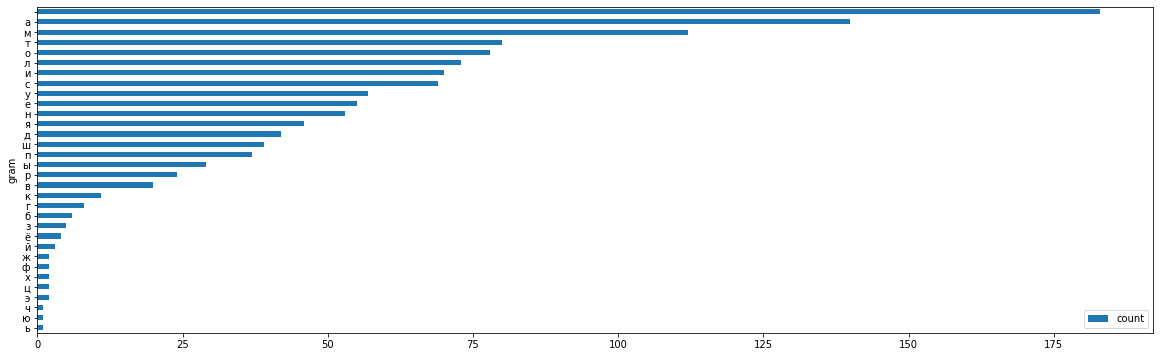

In [23]:
mini_ru_base = FreedomTokenizer(max_n=5,mode='chars',debug=False)
mini_ru_base.train(texts)
print(mini_ru_base.count_params())
dic = dict([(key,mini_ru_base.model[0][key]) for key in mini_ru_base.model[0] if len(key) == 1])
plot_dict(dic,'gram','count')

3700


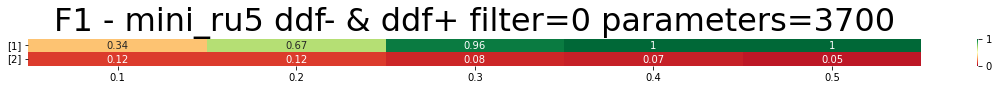

In [24]:
ref_tokenizer = DelimiterTokenizer()
thresholds = [0.1,0.2,0.3,0.4,0.5]#,0.6,0.7,0.8,0.9]
ngram_params = [[1],[2]]#,[3],[4],[5]]

print(mini_ru_base.count_params())
title = 'F1 - mini_ru5 ddf- & ddf+'
for filter_threshold in [0]:#,0.0001,0.001,0.01,0.1]:
    if filter_threshold > 0:
        model_compress_with_loss(mini_ru_base.model,filter_threshold)
    parameters = mini_ru_base.count_params()
    evaluate_freedom_tokenizer_options(texts,ref_tokenizer,FreedomBasedTokenizer(mini_ru_base,'ddf-','ddf+'),
        ngram_params,thresholds,title="{} filter={} parameters={}".format(title,filter_threshold,parameters))


['мама', ' ', 'мыла', ' ', 'машу', ' ', 'сплю', ' ', 'я', ' ', 'здесь']
['мама', ' ', 'мыла', ' ', 'машу', ' ', 'сплю', ' ', 'я', ' ', 'здесь']


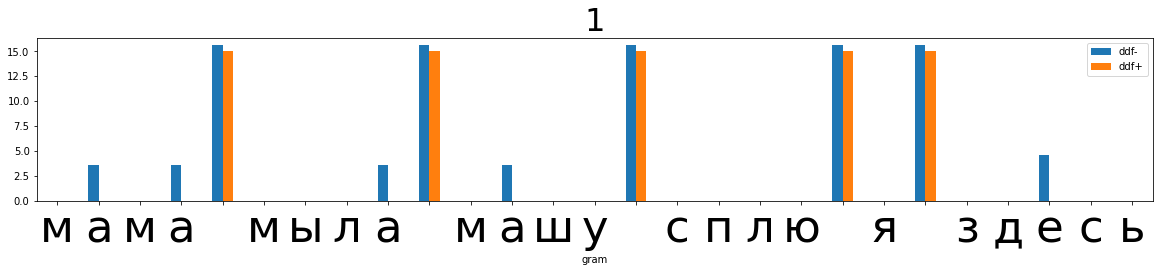

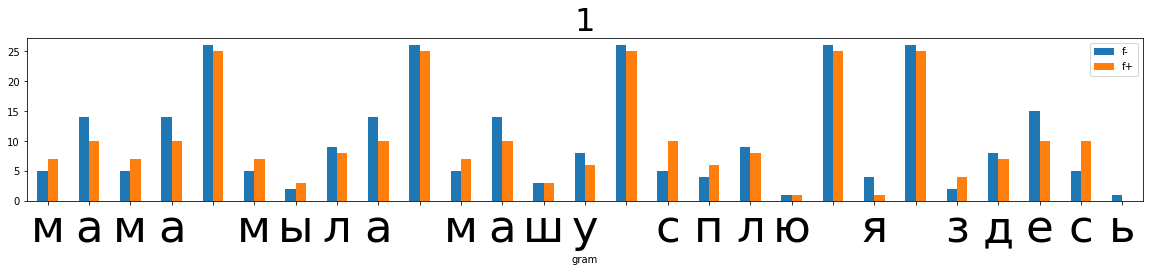

In [25]:
for i in range(1,1+1):
    tokenizer = FreedomBasedTokenizer(mini_ru_base,'ddf-','ddf+')
    print(ref_tokenizer.tokenize(test_text))
    tokenizer.set_options(nlist = [1], threshold=0.5)
    print(tokenizer.tokenize(test_text))
    df = profile_freedoms_ex_df(mini_ru_base.model,test_text,i)
    plot_bars(df,'gram',['ddf-','ddf+'],title=str(i))
    plot_bars(df,'gram',['f-','f+'],title=str(i))
    #plot_bars(df,'gram',['peak-','peak+'],title=str(i))


### Evaluate 1-st order structures WITH periods

5820


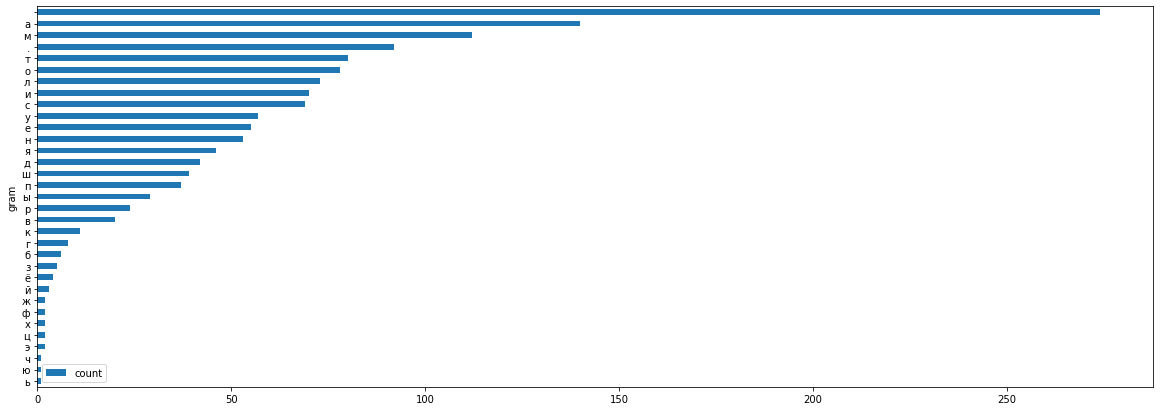

In [26]:
mini_ru_base = FreedomTokenizer(max_n=5,mode='chars',debug=False)
mini_ru_base.train([text_periods])
print(mini_ru_base.count_params())
dic = dict([(key,mini_ru_base.model[0][key]) for key in mini_ru_base.model[0] if len(key) == 1])
plot_dict(dic,'gram','count')

5820


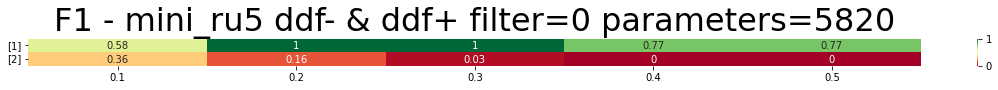

In [27]:
ref_tokenizer = DelimiterTokenizer()
thresholds = [0.1,0.2,0.3,0.4,0.5]#,0.6,0.7,0.8,0.9]
ngram_params = [[1],[2]]#,[3],[4],[5]]

print(mini_ru_base.count_params())
title = 'F1 - mini_ru5 ddf- & ddf+'
for filter_threshold in [0]:#,0.0001,0.001,0.01,0.1]:
    if filter_threshold > 0:
        model_compress_with_loss(mini_ru_base.model,filter_threshold)
    parameters = mini_ru_base.count_params()
    evaluate_freedom_tokenizer_options([text_periods],ref_tokenizer,FreedomBasedTokenizer(mini_ru_base,'ddf-','ddf+'),
        ngram_params,thresholds,title="{} filter={} parameters={}".format(title,filter_threshold,parameters))


['мама', ' ', 'мыла', ' ', 'машу', '.', ' ', 'сплю', ' ', 'я', ' ', 'здесь', '.']
['мама', ' ', 'мыла', ' ', 'машу', '.', ' ', 'сплю', ' ', 'я', ' ', 'здесь', '.']


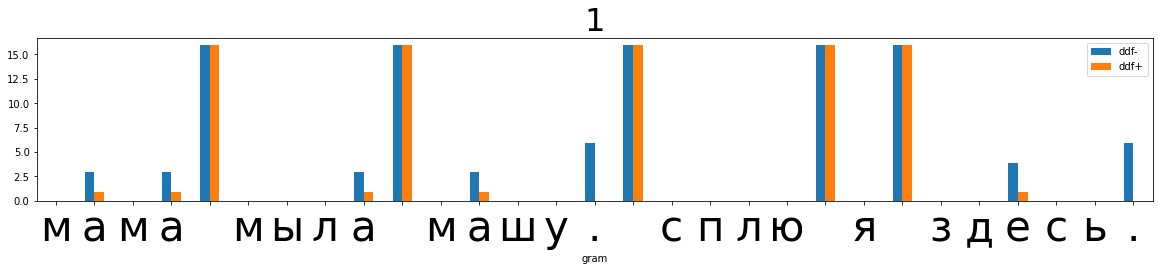

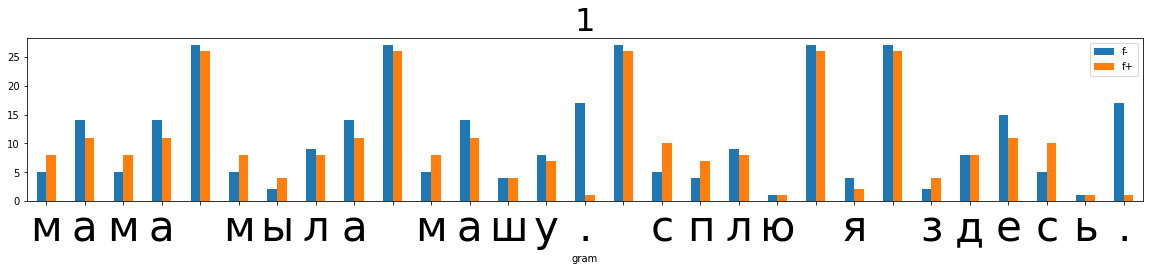

In [30]:
for i in range(1,1+1):
    tokenizer = FreedomBasedTokenizer(mini_ru_base,'ddf-','ddf+')
    print(ref_tokenizer.tokenize(test_text_periods))
    tokenizer.set_options(nlist = [1], threshold=0.3)
    print(tokenizer.tokenize(test_text_periods))
    df = profile_freedoms_ex_df(mini_ru_base.model,test_text_periods,i)
    plot_bars(df,'gram',['ddf-','ddf+'],title=str(i))
    plot_bars(df,'gram',['f-','f+'],title=str(i))
    #plot_bars(df,'gram',['peak-','peak+'],title=str(i))


### Evaluate 1-st order structures WITH periods with reference (trained on large data set) model

In [8]:
rusage_test_chars_7a = FreedomTokenizer(name='data/models/rusage_test_chars_7a',max_n=7,mode='chars',debug=False)
print(rusage_test_chars_7a.count_params())


75193666


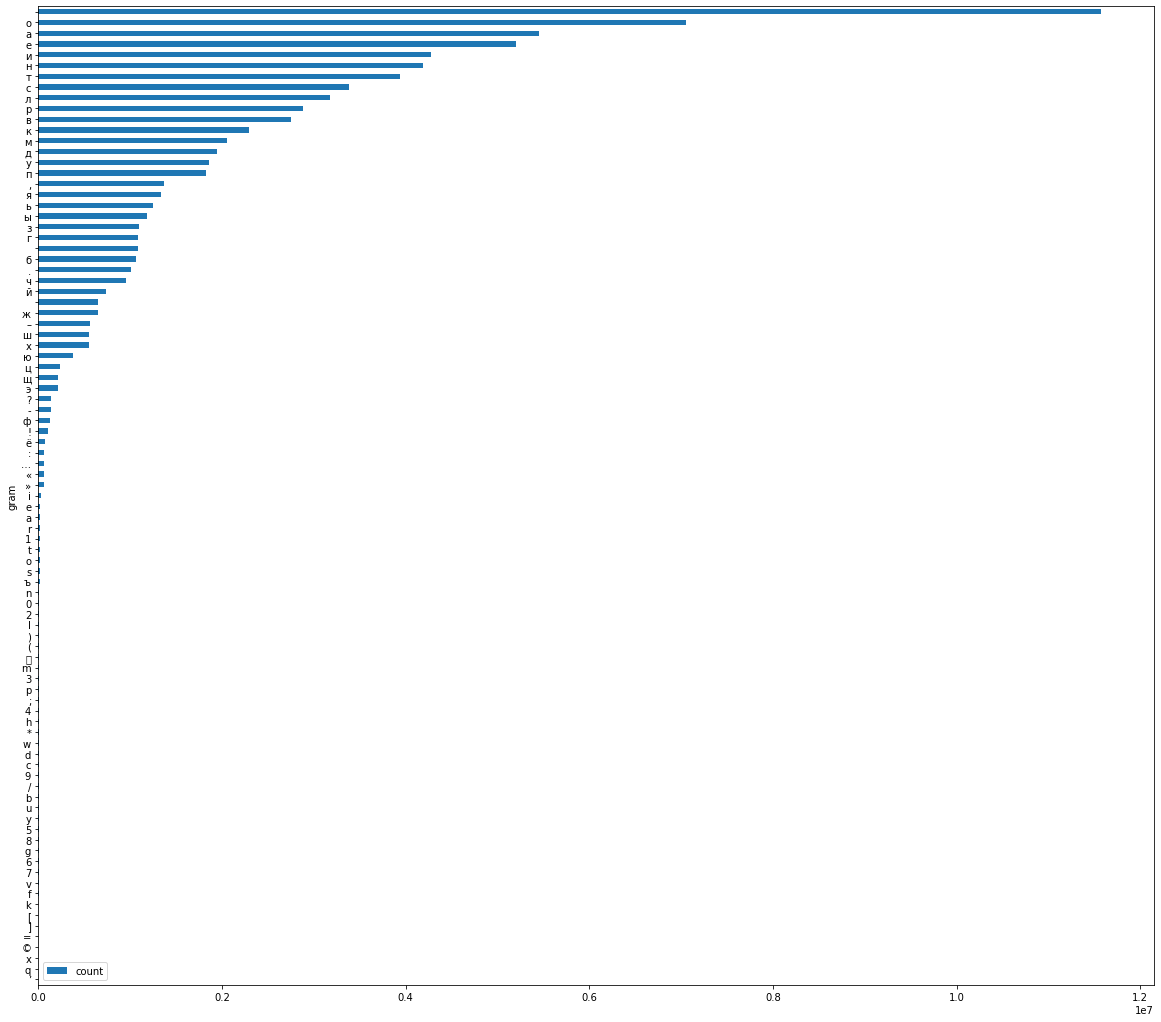

In [11]:
dic = dict([(key,rusage_test_chars_7a.model[0][key]) for key in rusage_test_chars_7a.model[0] if len(key) == 1 and rusage_test_chars_7a.model[0][key] >= 1000])
plot_dict(dic,'gram','count')


['мама', ' ', 'мыла', ' ', 'машу', '.', ' ', 'сплю', ' ', 'я', ' ', 'здесь', '.']
['мама', ' ', 'мыла', ' ', 'машу', '.', ' ', 'сплю', ' ', 'я', ' ', 'здесь', '.']


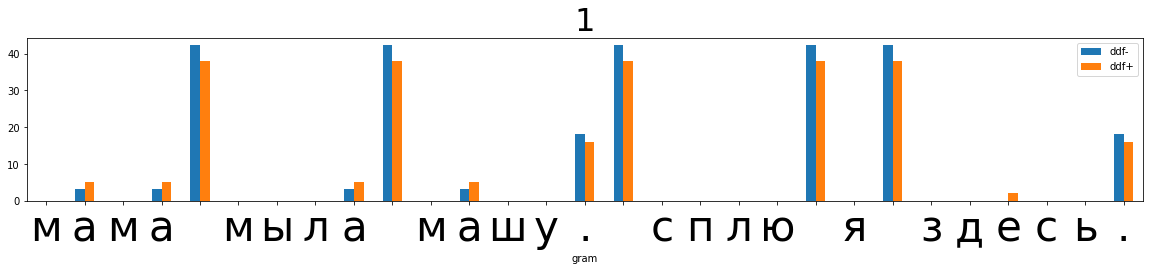

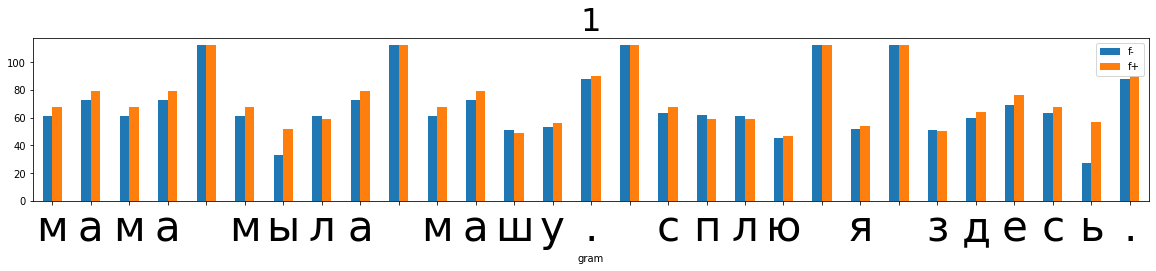

In [32]:
for i in range(1,1+1):
    tokenizer = FreedomBasedTokenizer(rusage_test_chars_7a,'ddf-','ddf+')
    print(ref_tokenizer.tokenize(test_text_periods))
    tokenizer.set_options(nlist = [1], threshold=0.3)
    print(tokenizer.tokenize(test_text_periods))
    df = profile_freedoms_ex_df(rusage_test_chars_7a.model,test_text_periods,i)
    plot_bars(df,'gram',['ddf-','ddf+'],title=str(i))
    plot_bars(df,'gram',['f-','f+'],title=str(i))
    #plot_bars(df,'gram',['peak-','peak+'],title=str(i))


In [ ]:
#TODO move data to data set
#TODO test same with English 
#TODO self-tune parameters for ~C and %S
#TODO 
